In [53]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
image_conversion = pd.read_csv("bench/image_conversion/image_conversion.csv")
_2mm = pd.read_csv("bench/2mm/2mm.csv")
_3mm = pd.read_csv("bench/3mm/3mm.csv")
vector_norm = pd.read_csv("bench/vector_norm/vector_norm.csv")
polynomial = pd.read_csv("bench/polynomial/polynomial.csv")

In [55]:
# combine "-O0" col from all dataframes into one dataframe
df = pd.concat([image_conversion, _2mm, _3mm, vector_norm, polynomial], ignore_index=True)
df

,name,opt,-O3
0,image_conversion,noopt,21944.0
1,image_conversion,eqsat+canon,19411.0
2,image_conversion,canon+eqsat,19349.0
3,image_conversion,eqsat,21735.5
4,image_conversion,canon,21436.0
5,2mm,noopt,116.5
6,2mm,canon,118.0
7,2mm,eqsat+canon,12.0
8,2mm,eqsat,11.0
9,2mm,canon+eqsat,13.0


In [56]:
# Renanem names to nice names
df['name'] = df['name'].replace({
    "image_conversion": "Image\nConversion",
    "2mm": "2MM",
    "3mm": "3MM",
    "vector_norm": "Vector\nNorm",
    "polynomial": "Polynomial"
})

df['opt'] = df['opt'].replace({
    "noopt": "No Optimization",
    "canon": "Canonicalization",
    "eqsat": "DialEgg",
    "eqsat+canon": "DialEgg + Canonicalization",
    "canon+eqsat": "Canonicalization + DialEgg",
    "cpp": "MLIR Hand-Writen Pass"
})

In [57]:
df_opt = df[['name', 'opt', "-O3"]]
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot

opt,Canonicalization,Canonicalization + DialEgg,DialEgg,DialEgg + Canonicalization,MLIR Hand-Writen Pass,No Optimization
name,,,,,,
2MM,118.0,13.0,11.0,12.0,12.0,116.5
3MM,9434.5,516.0,516.0,516.0,3894.5,8802.5
Image\nConversion,21436.0,19349.0,21735.5,19411.0,NaN,21944.0
Polynomial,2912.5,2964.5,2910.5,3016.0,NaN,2948.0
Vector\nNorm,3302.0,3157.0,3225.5,3465.5,NaN,3526.5


In [58]:
# speedup = baseline / optimized
(1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0)

opt,Canonicalization,Canonicalization + DialEgg,DialEgg,DialEgg + Canonicalization,MLIR Hand-Writen Pass,No Optimization
name,,,,,,
2MM,0.987288,8.961538,10.590909,9.708333,9.708333,1.0
3MM,0.933012,17.059109,17.059109,17.059109,2.260239,1.0
Image\nConversion,1.023698,1.134115,1.009593,1.130493,NaN,1.0
Polynomial,1.012189,0.994434,1.012884,0.977454,NaN,1.0
Vector\nNorm,1.067989,1.117041,1.093319,1.017602,NaN,1.0


In [59]:
# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
# Filter the dataframe for the current optimization level
df_opt = df[['name', 'opt', "-O3"]]

# Pivot the dataframe to have optimizations as columns
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot = df_pivot.drop(columns=['DialEgg + Canonicalization'], errors='ignore')

# Calculate speedup relative to 'noopt'
df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore') 

# order is Image Conversion, vector norm, polynomial, 2MM, 3MM
df_speedup = df_speedup.reindex(['Image\nConversion', 'Vector\nNorm', 'Polynomial', '2MM', '3MM'])
df_speedup

opt,Canonicalization,Canonicalization + DialEgg,DialEgg,MLIR Hand-Writen Pass
name,,,,
Image\nConversion,1.023698,1.134115,1.009593,NaN
Vector\nNorm,1.067989,1.117041,1.093319,NaN
Polynomial,1.012189,0.994434,1.012884,NaN
2MM,0.987288,8.961538,10.590909,9.708333
3MM,0.933012,17.059109,17.059109,2.260239


In [60]:
df_speedup.index

Index(['Image\nConversion', 'Vector\nNorm', 'Polynomial', '2MM', '3MM'], dtype='object', name='name')

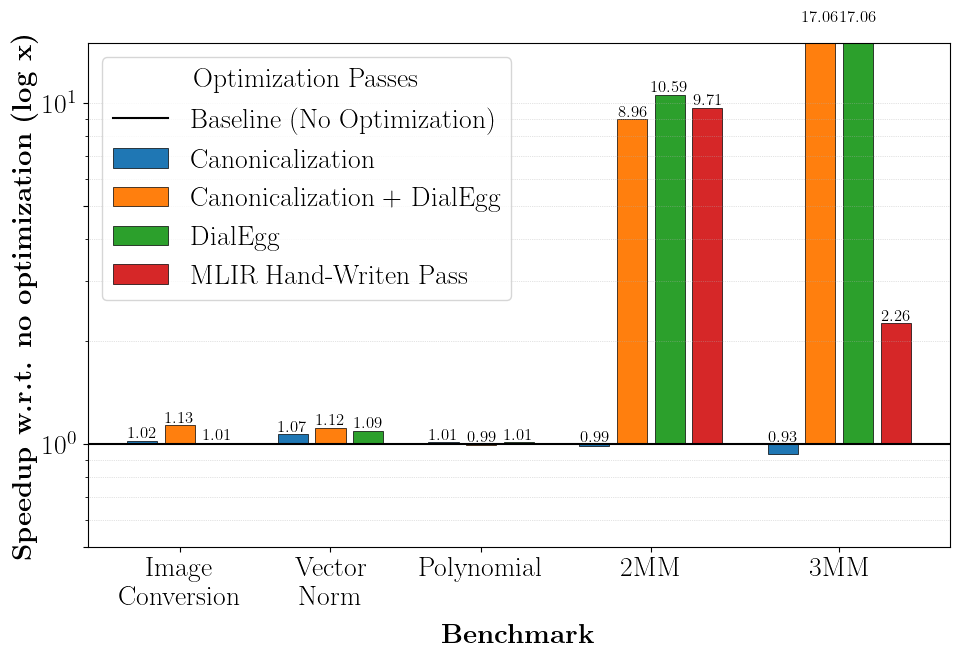

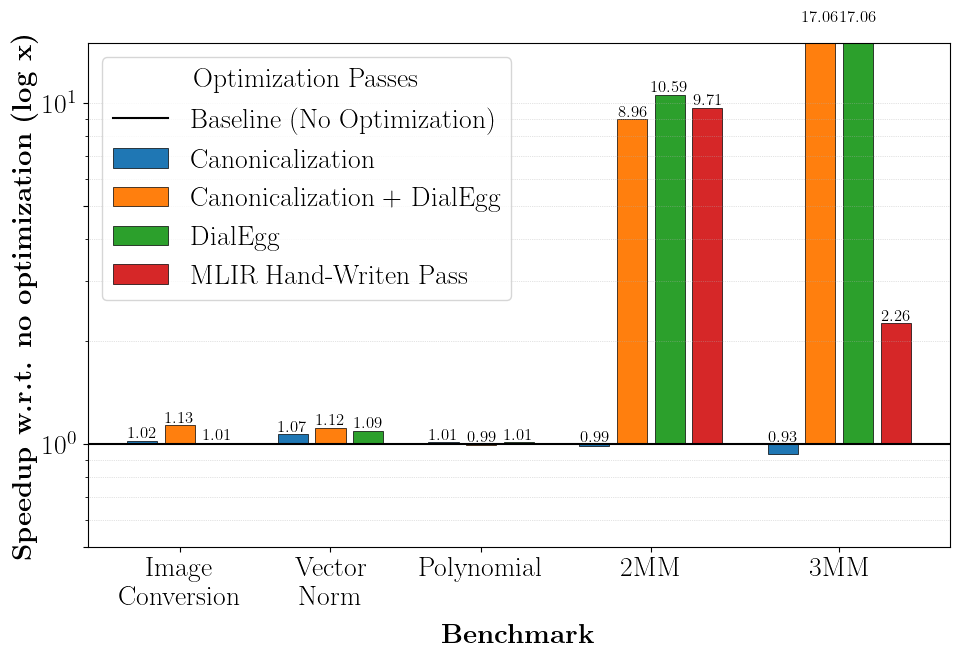

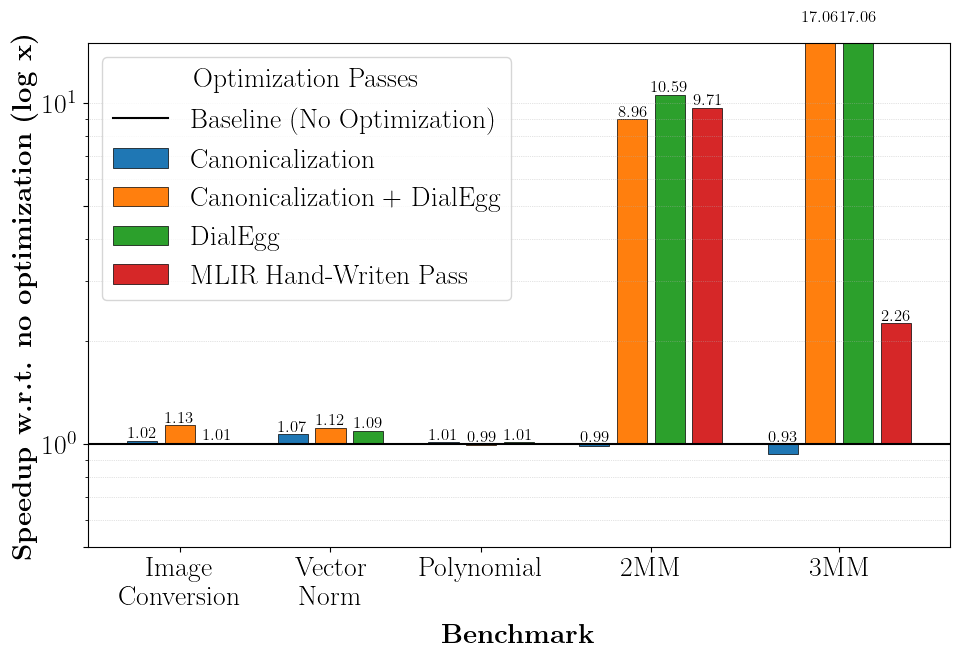

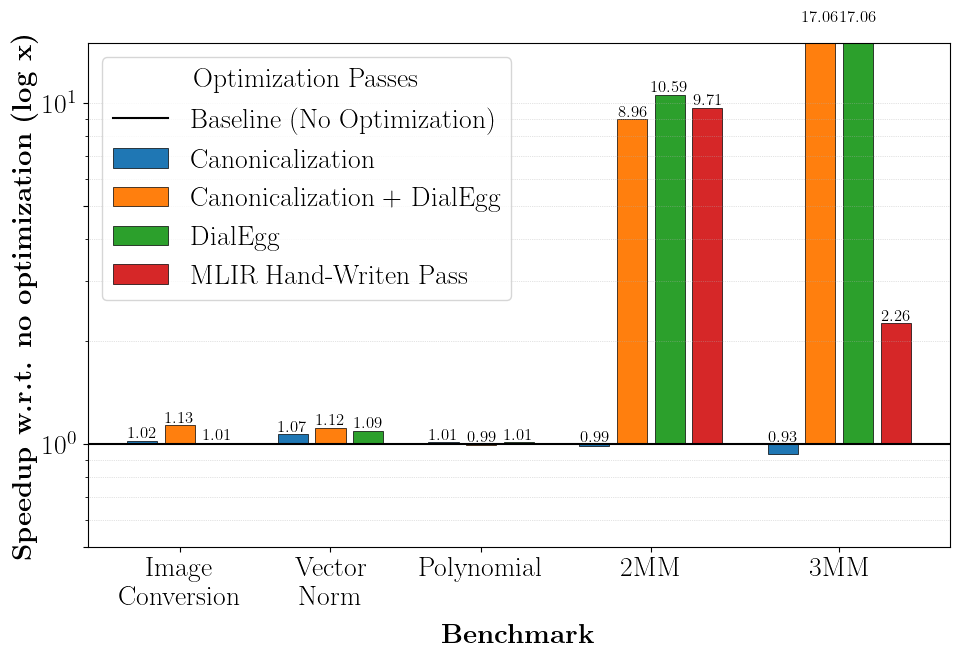

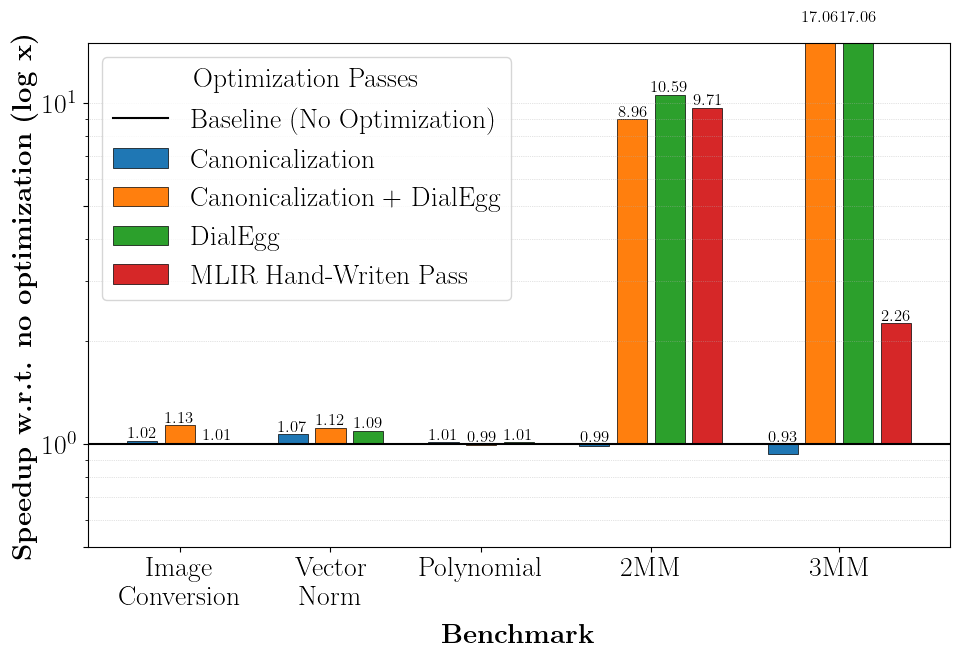

In [61]:
for i in range(5):
    # Create the speedup plot
    fig, ax = plt.subplots(figsize=(10, 7))

    bar_width = 0.20
    space = 0.050

    index = np.array([0, 1, 2, 3, 4.25])

    for i, col in enumerate(df_speedup.columns):
        bars = ax.bar(index + i * (bar_width + space), df_speedup[col] - 1, bar_width, 
                    label=col, bottom=1, edgecolor='black', linewidth=0.5)  # Bars start from 1

        # Add text labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):  # Skip NaN values
                ax.text(bar.get_x() + bar.get_width() / 2, max(0, height) + 1, f'{height + 1:.2f}', ha='center', va='bottom', fontsize=12)

    ax.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)

    plt.rc('text', usetex=True) # tex support
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)
    plt.rcParams.update({'font.size': 20})

    # Customize the plot
    plt.xlabel(r'\textbf{Benchmark}', labelpad=10, fontdict={'family': 'Libertine'})
    plt.ylabel(r'\textbf{Speedup w.r.t. no optimization (log x)}', fontdict={'family': 'Libertine', 'weight': 'bold'})
    ax.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')

    # Rotate x-axis labels for better readabilit
    ax.set_xticks(index + (bar_width / 2 + space + bar_width / 2) * np.array([1, 1, 1, 1.5, 1.5]))
    ax.set_xticklabels(df_speedup.index, rotation=0, ha='center')

    plt.yscale('log')
    plt.ylim(0.5, 15)
    plt.yticks([0.5, 1, 5, 10])

    ax.legend(title='Optimization Passes', loc='upper left', fontsize=20)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # save the plot to a file
    plt.savefig("bench/speedup.pdf")

    plt.show()